In [2]:
import heapq
from sklearn.datasets import make_blobs
import math
import random

from PIL import Image
import numpy as np
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
import networkx as nx

23_19_16


In [3]:
# Load the image

image_path = "images/xmas.png"  # Replace with your image path
image = Image.open(image_path)
image = image.convert("RGB")  # Ensure image is in RGB mode

# Get image dimensions
width, height = image.size

# Extract pixel values and store as RGB points
rgb_points = []
for y in range(height):
    for x in range(width):
        r, g, b = image.getpixel((x, y))
        rgb_points.append((r, g, b))

noise_level = 1  # Adjust noise level as needed
noisy_rgb_points = []

for point in rgb_points:
    noisy_point = tuple(
        np.clip(
            [int(c + random.uniform(-noise_level, noise_level)) for c in point], 0, 255
        )
    )
    noisy_rgb_points.append(noisy_point)


points = list(set(noisy_rgb_points))

In [5]:
# Load the image
image_path = "images/xmas.png"  # Replace with your image path
image = Image.open(image_path)
image = image.convert("RGB")  # Ensure image is in RGB mode

# Get image dimensions
width, height = image.size
print(width, height)

342 216


In [38]:
random.uniform(-noise_level, noise_level)

-0.4583273208756755

In [17]:
len(points) , len(noisy_rgb_points)

(11879, 73872)

In [6]:


class KDNode:
    def __init__(self, point, axis, left=None, right=None):
        self.point = point
        self.axis = axis
        self.left = left
        self.right = right


class KDTree:
    def __init__(self):
        self.root = None

    def build(self, points, depth=0):
        if not points:
            return None

        k = len(points[0])
        axis = depth % k

        points.sort(key=lambda x: x[axis])
        median = len(points) // 2

        return KDNode(
            point=points[median],
            axis=axis,
            left=self.build(points[:median], depth + 1),
            right=self.build(points[median + 1 :], depth + 1),
        )

    def insert(self, point):
        def _insert_rec(node, point, depth=0):
            if node is None:
                k = len(point)
                return KDNode(point, depth % k)

            if point[node.axis] < node.point[node.axis]:
                node.left = _insert_rec(node.left, point, depth + 1)
            else:
                node.right = _insert_rec(node.right, point, depth + 1)

            return node

        self.root = _insert_rec(self.root, point)


def i_neighbors(tree, query_point, i):
    if tree.root is None:
        return None
    i += 1
    neighbors = []
    visited = set()

    def _search(node):
        if node is None or node in visited:
            return

        visited.add(node)

        distance = sum([(a - b) ** 2 for a, b in zip(node.point, query_point)]) ** 0.5

        if len(neighbors) < i:
            heapq.heappush(neighbors, (-distance, node.point))
        else:
            if distance < -neighbors[0][0]:
                heapq.heappop(neighbors)
                heapq.heappush(neighbors, (-distance, node.point))

        axis = node.axis
        next_branch = node.left if query_point[axis] < node.point[axis] else node.right
        opposite_branch = (
            node.right if query_point[axis] < node.point[axis] else node.left
        )

        _search(next_branch)

        if (
            len(neighbors) < i
            or abs(query_point[axis] - node.point[axis]) < -neighbors[0][0]
        ):
            _search(opposite_branch)

    _search(tree.root)
    neighbors.sort(key=lambda x: -x[0])
    neighbors = [(-d, p) for d, p in neighbors]
    return neighbors[1 : i + 1]


def brute_force_neighbors(points, query_point, i):
    distances = []
    for point in points:
        distance = sum([(a - b) ** 2 for a, b in zip(point, query_point)]) ** 0.5
        distances.append((distance, point))
    distances.sort(key=lambda x: x[0])
    return distances[1 : i + 1]


def verify_kd_tree(tree, points, query_point, i):
    kd_neighbors = i_neighbors(tree, query_point, i)
    bf_neighbors = brute_force_neighbors(points, query_point, i)

    kd_points = [p for _, p in kd_neighbors]
    bf_points = [p for _, p in bf_neighbors]

    return kd_points == bf_points



In [7]:
def euclidean_distance(point1, point2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))

In [8]:
def plot_3d_graph(G):
    pos = nx.get_node_attributes(G, "pos")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    for edge in G.edges():
        x = [pos[edge[0]][0], pos[edge[1]][0]]
        y = [pos[edge[0]][1], pos[edge[1]][1]]
        z = [pos[edge[0]][2], pos[edge[1]][2]]
        ax.plot(x, y, z, color="b")

    xs = [pos[key][0] for key in pos]
    ys = [pos[key][1] for key in pos]
    zs = [pos[key][2] for key in pos]
    ax.scatter(xs, ys, zs, c="r", marker="o")

    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    plt.title("3D NetworkX Graph")
    plt.show()

In [9]:
def round_coordinates(points, decimals=1):
    return [tuple(round(coord, decimals) for coord in point) for point in points]

In [10]:
# Install dependencies (uncomment and run in a terminal or notebook cell)

# Generate 3D points with 3 clusters
# n_samples = 50
# n_features = 3
# n_clusters = 1

# X, y = make_blobs(
#     n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42
# )

# points = [tuple(point) for point in X.tolist()]
# points = round_coordinates(points, decimals=1)
maxdis = math.ceil(math.log2(len(points)))

In [11]:
def build():
    tree = KDTree()

    tree.root = tree.build(points)

    # NetworkX graph construction
    G = nx.Graph()
    for point in points:
        G.add_node(tuple(point), pos=tuple(point))

    neighbours = {}
    
    for point in points:
        neighbours[point] = i_neighbors(tree, point, maxdis)
    return G, neighbours

In [12]:
G, neighbours = build()
print(G.number_of_nodes(), G.number_of_edges())
k = 0
while k < maxdis:

    print("Connected Components : ", len(list(nx.connected_components(G))))
    if (len(connected_components := list(nx.connected_components(G)))) == 1:
        break
    print(
            f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges."
        )
    G_prev = deepcopy(G)
    for component in connected_components:
        for node in component:
            wt, pos = neighbours[node][k]
            if pos in component:
                continue
            # print(f"Adding edge between {node} and {pos} with weight {wt}")
            G.add_edge(node, pos, weight=wt)
    k += 1
    # plot_3d_graph(G)
print(G.number_of_nodes(), G.number_of_edges())

11879 0
Connected Components :  11879
The graph has 11879 nodes and 0 edges.
Connected Components :  2164
The graph has 11879 nodes and 9756 edges.
Connected Components :  95
The graph has 11879 nodes and 14761 edges.
Connected Components :  13
The graph has 11879 nodes and 15006 edges.
Connected Components :  4
The graph has 11879 nodes and 15031 edges.
Connected Components :  1
11879 15044


In [13]:
print(
    G_prev.number_of_nodes(),
    G_prev.number_of_edges(),
    len(list(nx.connected_components(G_prev))),
)

11879 15031 4


In [14]:
color_c_map = {}
for component in list(nx.connected_components(G_prev)):
    print(len(component))
    random_color = tuple(random.randint(0, 255) for _ in range(3))
    print(f"Random Color: {random_color}")
    for node in component:
        color_c_map[node] = random_color

5
Random Color: (131, 178, 44)
11862
Random Color: (87, 253, 121)
7
Random Color: (107, 109, 158)
5
Random Color: (213, 70, 144)


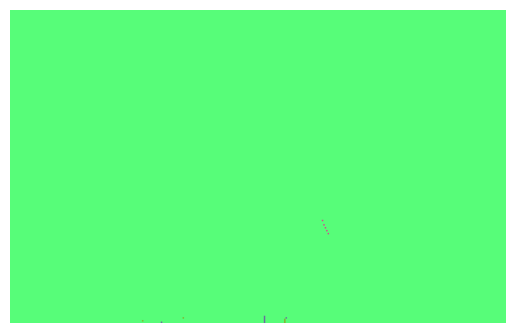

In [15]:
new_image = Image.new("RGB", (width, height))
pixels = new_image.load()

idx = 0
for y in range(height):
    for x in range(width):
        original_color = noisy_rgb_points[idx]
        new_color = color_c_map[original_color]
        pixels[x, y] = new_color
        idx += 1

# Display the modified image
plt.imshow(new_image)
plt.axis("off")
plt.show()

11879 11878


KeyboardInterrupt: 

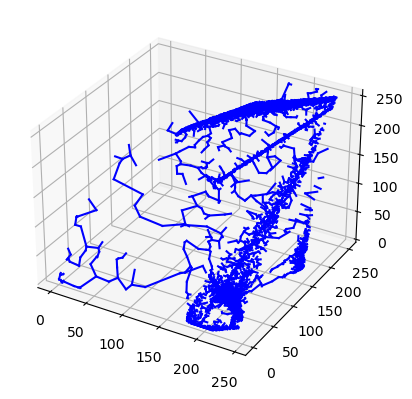

In [16]:
mst = nx.minimum_spanning_tree(G)
print(mst.number_of_nodes(), mst.number_of_edges())
plot_3d_graph(mst)

In [ ]:
for node, attr in G.nodes(data=True):
    print(f"Point: {node}, Position: {attr['pos']}")

Point: (0, 5, 12), Position: (0, 5, 12)
Point: (0, 4, 10), Position: (0, 4, 10)
Point: (0, 1, 4), Position: (0, 1, 4)
Point: (0, 2, 4), Position: (0, 2, 4)
Point: (0, 3, 9), Position: (0, 3, 9)
Point: (2, 0, 3), Position: (2, 0, 3)
Point: (4, 16, 33), Position: (4, 16, 33)
Point: (4, 0, 2), Position: (4, 0, 2)
Point: (4, 5, 12), Position: (4, 5, 12)
Point: (5, 12, 34), Position: (5, 12, 34)
Point: (5, 13, 52), Position: (5, 13, 52)
Point: (5, 4, 11), Position: (5, 4, 11)
Point: (6, 0, 0), Position: (6, 0, 0)
Point: (7, 1, 4), Position: (7, 1, 4)
Point: (7, 1, 3), Position: (7, 1, 3)
Point: (8, 16, 29), Position: (8, 16, 29)
Point: (8, 0, 3), Position: (8, 0, 3)
Point: (9, 25, 87), Position: (9, 25, 87)
Point: (10, 29, 98), Position: (10, 29, 98)
Point: (10, 13, 43), Position: (10, 13, 43)
Point: (10, 28, 98), Position: (10, 28, 98)
Point: (12, 34, 80), Position: (12, 34, 80)
Point: (14, 52, 115), Position: (14, 52, 115)
Point: (17, 17, 23), Position: (17, 17, 23)
Point: (18, 23, 34), P

In [ ]:
total_weight = 0
print("\nEdges in the MST and their weights (calculated manually):")
for edge in mst.edges():
    point1, point2 = edge
    weight = euclidean_distance(point1, point2)
    print(f"Edge: {point1} - {point2}, Weight: {weight}")
    total_weight += weight

print(f"\nTotal weight of the Minimum Spanning Tree: {total_weight}")


Edges in the MST and their weights (calculated manually):
Edge: (0, 5, 12) - (0, 4, 10), Weight: 2.23606797749979
Edge: (0, 5, 12) - (4, 5, 12), Weight: 4.0
Edge: (0, 4, 10) - (0, 3, 9), Weight: 1.4142135623730951
Edge: (0, 1, 4) - (0, 2, 4), Weight: 1.0
Edge: (0, 1, 4) - (2, 0, 3), Weight: 2.449489742783178
Edge: (0, 2, 4) - (0, 3, 9), Weight: 5.0990195135927845
Edge: (2, 0, 3) - (4, 0, 2), Weight: 2.23606797749979
Edge: (4, 16, 33) - (5, 12, 34), Weight: 4.242640687119285
Edge: (4, 16, 33) - (8, 16, 29), Weight: 5.656854249492381
Edge: (4, 0, 2) - (6, 0, 0), Weight: 2.8284271247461903
Edge: (4, 5, 12) - (5, 4, 11), Weight: 1.7320508075688772
Edge: (5, 12, 34) - (10, 13, 43), Weight: 10.344080432788601
Edge: (5, 13, 52) - (10, 13, 43), Weight: 10.295630140987
Edge: (6, 0, 0) - (7, 1, 3), Weight: 3.3166247903554
Edge: (7, 1, 4) - (7, 1, 3), Weight: 1.0
Edge: (7, 1, 3) - (8, 0, 3), Weight: 1.4142135623730951
Edge: (8, 16, 29) - (17, 17, 23), Weight: 10.862780491200215
Edge: (8, 0, 3) -

In [ ]:
# complete_graph = nx.Graph()
# for point in points:
#     complete_graph.add_node(point, pos=point)

# # Add edges with Euclidean distance as weights
# for i, point1 in enumerate(points):
#     for j, point2 in enumerate(points):
#         if i != j:
#             distance = euclidean_distance(point1, point2)
#             complete_graph.add_edge(point1, point2, weight=distance)

# # Print points and their positions
# print("Points and their positions in the graph:")
# for node, attr in complete_graph.nodes(data=True):
#     print(f"Point: {node}, Position: {attr['pos']}")

# # Calculate the MST using NetworkX's minimum_spanning_tree function
# mst_graph = nx.minimum_spanning_tree(complete_graph)

# # Calculate the total weight of the MST
# total_weight = 0
# print("\nEdges in the MST and their weights:")
# for edge in mst_graph.edges(data=True):
#     print(f"Edge: {edge[0]} - {edge[1]}, Weight: {edge[2]['weight']}")
#     total_weight += edge[2]["weight"]

# print(f"\nTotal weight of the Minimum Spanning Tree: {total_weight}")

In [39]:
from PIL import Image
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# Load the image
image_path = "images/xmas.png"  # Replace with your image path
image = Image.open(image_path)
image = image.convert("RGB")  # Ensure image is in RGB mode

# Get image dimensions
width, height = image.size

# Extract pixel values and store as RGB points
rgb_points = []
for y in range(height):
    for x in range(width):
        r, g, b = image.getpixel((x, y))
        rgb_points.append((r, g, b))

# Add noise to ensure each point is unique
noise_level = 0.5  # Small noise level
noisy_rgb_points = []

for point in rgb_points:
    noisy_point = tuple(
        np.clip(
            [int(c + random.uniform(-noise_level, noise_level)) for c in point], 0, 255
        )
    )
    noisy_rgb_points.append(noisy_point)

# Create a graph with nodes for each unique RGB point
G = nx.Graph()
for point in noisy_rgb_points:
    G.add_node(point, pos=point)

# Add edges with Euclidean distance as weights
for i, point1 in enumerate(noisy_rgb_points):
    for j, point2 in enumerate(noisy_rgb_points):
        if i < j:
            distance = np.linalg.norm(np.array(point1) - np.array(point2))
            G.add_edge(point1, point2, weight=distance)

# Compute the MST
mst = nx.minimum_spanning_tree(G)

# Sort edges by weight in descending order to break the largest edges
edges_sorted_by_weight = sorted(
    mst.edges(data=True), key=lambda x: x[2]["weight"], reverse=True
)

# Determine the number of clusters
num_clusters = 5  # Adjust the number of clusters as needed

# Remove the largest edges to form clusters
for i in range(num_clusters - 1):
    edge_to_remove = edges_sorted_by_weight[i]
    mst.remove_edge(edge_to_remove[0], edge_to_remove[1])

# Find connected components (clusters)
connected_components = list(nx.connected_components(mst))

# Assign a representative color for each cluster
color_c_map = {}
for component in connected_components:
    random_color = tuple(random.randint(0, 255) for _ in range(3))
    for node in component:
        color_c_map[node] = random_color

# Create a new image with modified colors
new_image = Image.new("RGB", (width, height))
pixels = new_image.load()

idx = 0
for y in range(height):
    for x in range(width):
        original_color = noisy_rgb_points[idx]
        new_color = color_c_map[original_color]
        pixels[x, y] = new_color
        idx += 1

# Display the modified image
plt.imshow(new_image)
plt.axis("off")
plt.show()

KeyboardInterrupt: 

In [1]:
# Load the image
image_path = "images/xmas.png"  # Replace with your image path
image = Image.open(image_path)
image = image.convert("RGB")  # Ensure image is in RGB mode

# Get image dimensions
width, height = image.size

NameError: name 'Image' is not defined

In [ ]:
len((points))

11837

In [6]:
import numpy as np
import cv2
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("images/xmas.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_resized = cv2.resize(image, (32, 32))

# Reshape the image to a 2D array of pixels
pixels = image_resized.reshape(-1, 3)

# Normalize pixel values
pixels = pixels / 255.0

In [7]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree

# Compute the pairwise distance matrix
distances = pdist(pixels, metric="euclidean")
distance_matrix = squareform(distances)

# Compute the Minimum Spanning Tree
mst = minimum_spanning_tree(distance_matrix).toarray()

In [8]:
# Convert MST to a format suitable for clustering
mst[mst > 0] = 1

# Perform clustering using Agglomerative Clustering on MST
n_clusters = 10  # You can change the number of clusters
clustering = AgglomerativeClustering(
    n_clusters=n_clusters, affinity="precomputed", linkage="average"
)
clusters = clustering.fit_predict(mst)

/home/voy/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [11]:
new_pixels = np.zeros_like(pixels)

# Compute the mean color for each cluster and assign it to the corresponding pixels
for cluster in range(n_clusters):
    cluster_indices = np.where(clusters == cluster)[0]
    mean_color = np.mean(pixels[cluster_indices], axis=0)
    new_pixels[cluster_indices] = mean_color

# Reshape the pixel array back to the original image shape
new_image = (new_pixels * 255).astype(np.uint8).reshape(image_resized.shape)

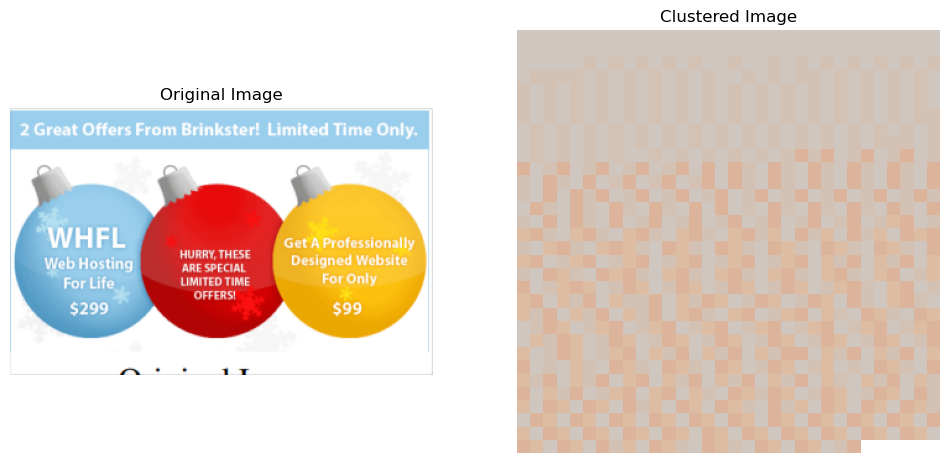

In [12]:
# Display the original and the new image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(new_image)
axes[1].set_title("Clustered Image")
axes[1].axis("off")

plt.show()

/home/voy/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


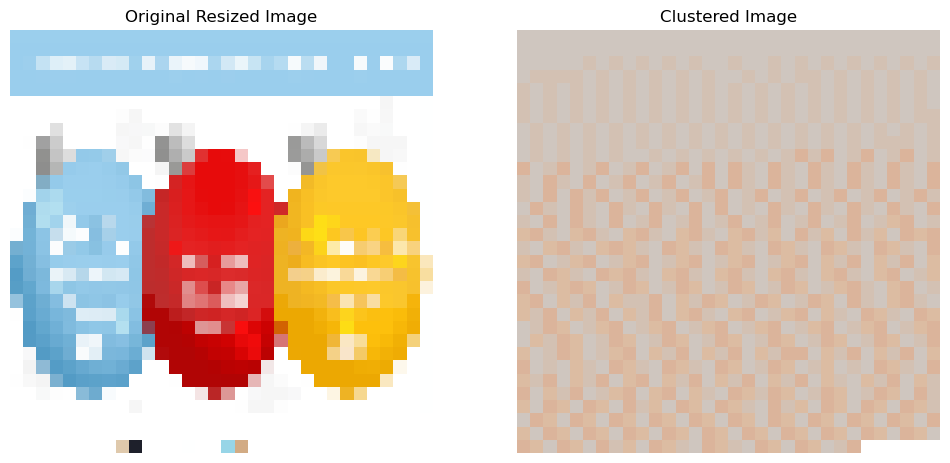

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree

# Load the image
image_path = "images/xmas.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize the image to 32x32
image_resized = cv2.resize(image, (32, 32))

# Reshape the image to a 2D array of pixels
pixels = image_resized.reshape(-1, 3)

# Normalize pixel values
pixels = pixels / 255.0

# Compute the pairwise distance matrix
distances = pdist(pixels, metric="euclidean")
distance_matrix = squareform(distances)

# Compute the Minimum Spanning Tree
mst = minimum_spanning_tree(distance_matrix).toarray()

# Convert MST to a format suitable for clustering
mst[mst > 0] = 1

# Perform clustering using Agglomerative Clustering on MST
n_clusters = 10  # You can change the number of clusters
clustering = AgglomerativeClustering(
    n_clusters=n_clusters, affinity="precomputed", linkage="average"
)
clusters = clustering.fit_predict(mst)

# Create an array to store the new pixel values
new_pixels = np.zeros_like(pixels)

# Compute the mean color for each cluster and assign it to the corresponding pixels
for cluster in range(n_clusters):
    cluster_indices = np.where(clusters == cluster)[0]
    mean_color = np.mean(pixels[cluster_indices], axis=0)
    new_pixels[cluster_indices] = mean_color

# Reshape the pixel array back to the original image shape
new_image = (new_pixels * 255).astype(np.uint8).reshape(image_resized.shape)

# Display the original and the new image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_resized)
axes[0].set_title("Original Resized Image")
axes[0].axis("off")

axes[1].imshow(new_image)
axes[1].set_title("Clustered Image")
axes[1].axis("off")

plt.show()

/home/voy/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


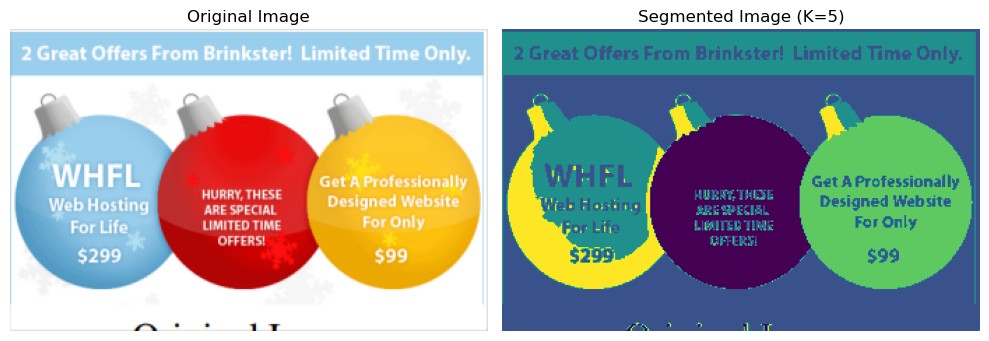

In [14]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
img = Image.open("images/xmas.png")

# Convert the image to a numpy array
img_array = np.array(img)

# Reshape the array to a 2D matrix of pixels
pixels = img_array.reshape(-1, 3)

# Specify the number of clusters (segments) you want
num_clusters = 5

# Create a KMeans clustering model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model to the pixel data
kmeans.fit(pixels)

# Get the cluster labels for each pixel
labels = kmeans.labels_

# Reshape the labels back into the original image shape
segmented_img = labels.reshape(img_array.shape[:2])

# Create a plot to display the original and segmented images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(segmented_img, cmap="viridis")
ax2.set_title(f"Segmented Image (K={num_clusters})")
ax2.axis("off")

plt.tight_layout()
plt.show()

Loading image from: images/xmas.png
Original image shape: (216, 342, 3)
Reshaping image for unique color extraction
Number of unique colors: 8544
Creating graph with nodes as unique colors
Computing Minimum Spanning Tree
Extracting edges and weights from MST
Number of edges in MST: 8543
Performing Agglomerative Clustering
Clustering labels: [0 0 0 ... 4 4 4]
Mapping cluster labels to unique colors
Labels assigned to unique colors: [3 1 3 ... 0 0 1]
Finding most common color in each cluster
Cluster 0: Most common color (4, 5, 12)
Cluster 1: Most common color (0, 4, 10)
Cluster 2: Most common color (13, 34, 80)
Cluster 3: Most common color (0, 2, 5)
Cluster 4: Most common color (5, 16, 34)
Mapping most common colors back to the image
Displaying images


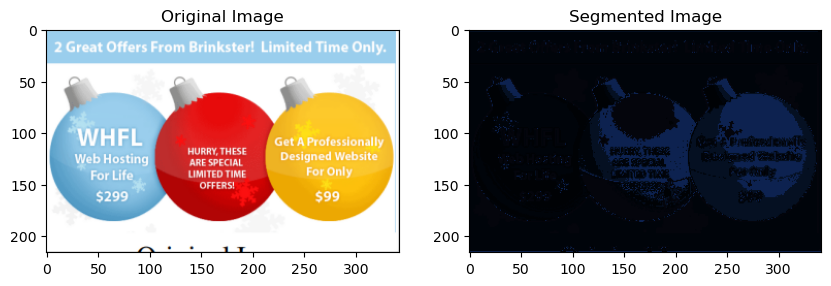

In [4]:
import numpy as np
import cv2
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from collections import Counter

# Load and resize the image
image_path = "images/xmas.png"
print("Loading image from:", image_path)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Original image shape:", image.shape)
# resized_image = cv2.resize(image, (32, 32))
resized_image = image

# Get unique colors in the image
print("Reshaping image for unique color extraction")
unique_colors, unique_indices = np.unique(
    resized_image.reshape(-1, resized_image.shape[2]), axis=0, return_inverse=True
)
print("Number of unique colors:", unique_colors.shape[0])

# Create a graph where each node is a unique color and edges are the RGB differences
print("Creating graph with nodes as unique colors")
G = nx.Graph()
num_colors = unique_colors.shape[0]
for i in range(num_colors):
    G.add_node(i, color=tuple(unique_colors[i]))
    for j in range(i + 1, num_colors):
        weight = np.linalg.norm(unique_colors[i] - unique_colors[j])
        G.add_edge(i, j, weight=weight)

# Apply Minimum Spanning Tree
print("Computing Minimum Spanning Tree")
mst = nx.minimum_spanning_tree(G)

# Clustering using Agglomerative Clustering on the MST
print("Extracting edges and weights from MST")
edges = list(mst.edges(data=True))
weights = np.array([edge[2]["weight"] for edge in edges])
print("Number of edges in MST:", len(edges))

# Perform clustering on the weights of the MST
print("Performing Agglomerative Clustering")
clustering = AgglomerativeClustering(n_clusters=min(5, num_colors), linkage="ward").fit(
    weights.reshape(-1, 1)
)
print("Clustering labels:", clustering.labels_)

# Ensure the number of labels matches the number of unique colors
print("Mapping cluster labels to unique colors")
labels = np.zeros(num_colors, dtype=int)
for i, (u, v, data) in enumerate(edges):
    label = clustering.labels_[i]
    labels[u] = label
    labels[v] = label

print("Labels assigned to unique colors:", labels)

# Find the most common color in each cluster
print("Finding most common color in each cluster")
cluster_colors = np.zeros((np.max(labels) + 1, 3), dtype=int)
for cluster in range(np.max(labels) + 1):
    cluster_indices = np.where(labels == cluster)[0]
    cluster_colors_list = unique_colors[cluster_indices]
    most_common_color = Counter(map(tuple, cluster_colors_list)).most_common(1)[0][0]
    cluster_colors[cluster] = most_common_color
    print(f"Cluster {cluster}: Most common color {most_common_color}")

# Map the most common colors back to the image
print("Mapping most common colors back to the image")
segmented_image = np.zeros_like(resized_image)
for index, unique_index in enumerate(unique_indices):
    y = index // resized_image.shape[1]
    x = index % resized_image.shape[1]
    segmented_image[y, x] = cluster_colors[labels[unique_index]]

# Display the original and segmented images
print("Displaying images")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(resized_image)
plt.subplot(1, 2, 2)
plt.title("Segmented Image")
plt.imshow(segmented_image)
plt.show()

In [30]:
print(G)

Graph with 1024 nodes and 1984 edges


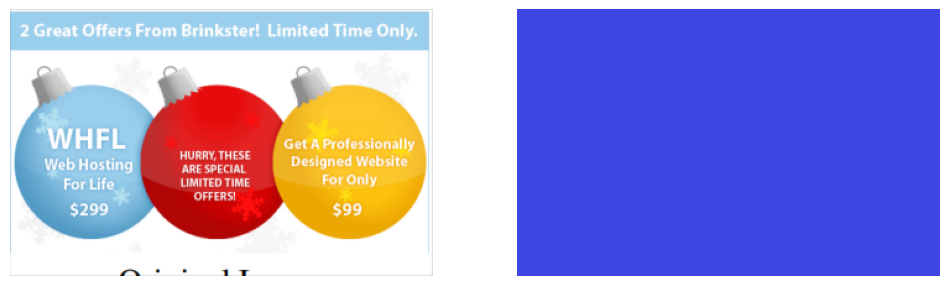

In [2]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("/home/voy/space/cud/dcrun/images/xmas.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get image dimensions
height, width, _ = image.shape

# Convert image to a graph
G = nx.Graph()

# Add nodes for each pixel
for y in range(height):
    for x in range(width):
        G.add_node((x, y), color=tuple(image[y, x]))

# Add edges between neighboring pixels
for y in range(height):
    for x in range(width):
        if x < width - 1:
            color_diff = np.linalg.norm(image[y, x] - image[y, x + 1])
            G.add_edge((x, y), (x + 1, y), weight=color_diff)
        if y < height - 1:
            color_diff = np.linalg.norm(image[y, x] - image[y + 1, x])
            G.add_edge((x, y), (x, y + 1), weight=color_diff)

# Compute the Minimum Spanning Tree (MST)
mst = nx.minimum_spanning_tree(G)

# Segment the image using the MST
segments = np.zeros((height, width, 3), dtype=np.uint8)

# Assign colors to segments
for component in nx.connected_components(mst):
    color = np.random.randint(0, 255, 3)
    for node in component:
        segments[node[1], node[0]] = color

# Plot the original image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")

# Plot the segmented image
plt.subplot(1, 2, 2)
plt.imshow(segments)
plt.axis("off")

plt.show()

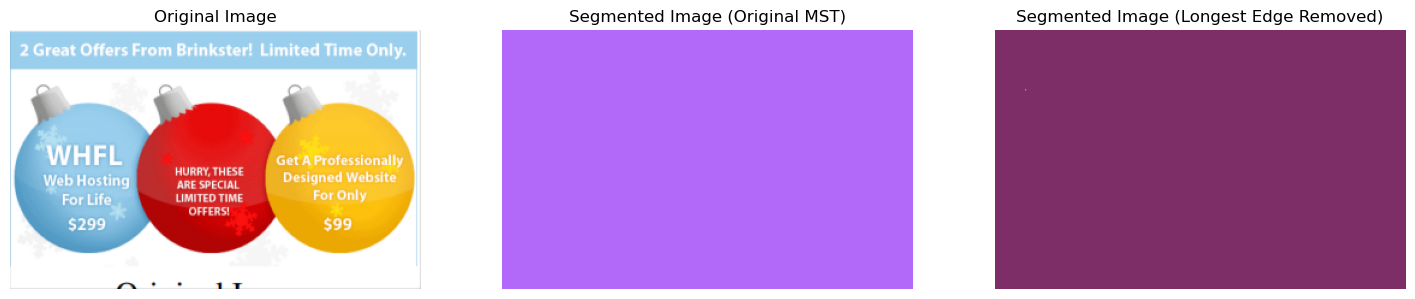

In [3]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("/home/voy/space/cud/dcrun/images/xmas.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get image dimensions
height, width, _ = image.shape

# Convert image to a graph
G = nx.Graph()

# Add nodes for each pixel
for y in range(height):
    for x in range(width):
        G.add_node((x, y), color=tuple(image[y, x]))

# Add edges between neighboring pixels
for y in range(height):
    for x in range(width):
        if x < width - 1:
            color_diff = np.linalg.norm(image[y, x] - image[y, x + 1])
            G.add_edge((x, y), (x + 1, y), weight=color_diff)
        if y < height - 1:
            color_diff = np.linalg.norm(image[y, x] - image[y + 1, x])
            G.add_edge((x, y), (x, y + 1), weight=color_diff)

# Compute the Minimum Spanning Tree (MST)
mst = nx.minimum_spanning_tree(G)


# Function to segment image using MST
def segment_image(mst):
    segments = np.zeros((height, width, 3), dtype=np.uint8)
    for component in nx.connected_components(mst):
        color = np.random.randint(0, 255, 3)
        for node in component:
            segments[node[1], node[0]] = color
    return segments


# Plot original segmentation
segments_original = segment_image(mst)

# Find and remove the longest edge
longest_edge = max(mst.edges(data=True), key=lambda t: t[2]["weight"])
mst.remove_edge(longest_edge[0], longest_edge[1])

# Plot segmentation after removing the longest edge
segments_removed_edge = segment_image(mst)

# Plot the original image and segmentations
plt.figure(figsize=(18, 6))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

# Segmentation with original MST
plt.subplot(1, 3, 2)
plt.imshow(segments_original)
plt.axis("off")
plt.title("Segmented Image (Original MST)")

# Segmentation after removing the longest edge
plt.subplot(1, 3, 3)
plt.imshow(segments_removed_edge)
plt.axis("off")
plt.title("Segmented Image (Longest Edge Removed)")

plt.show()

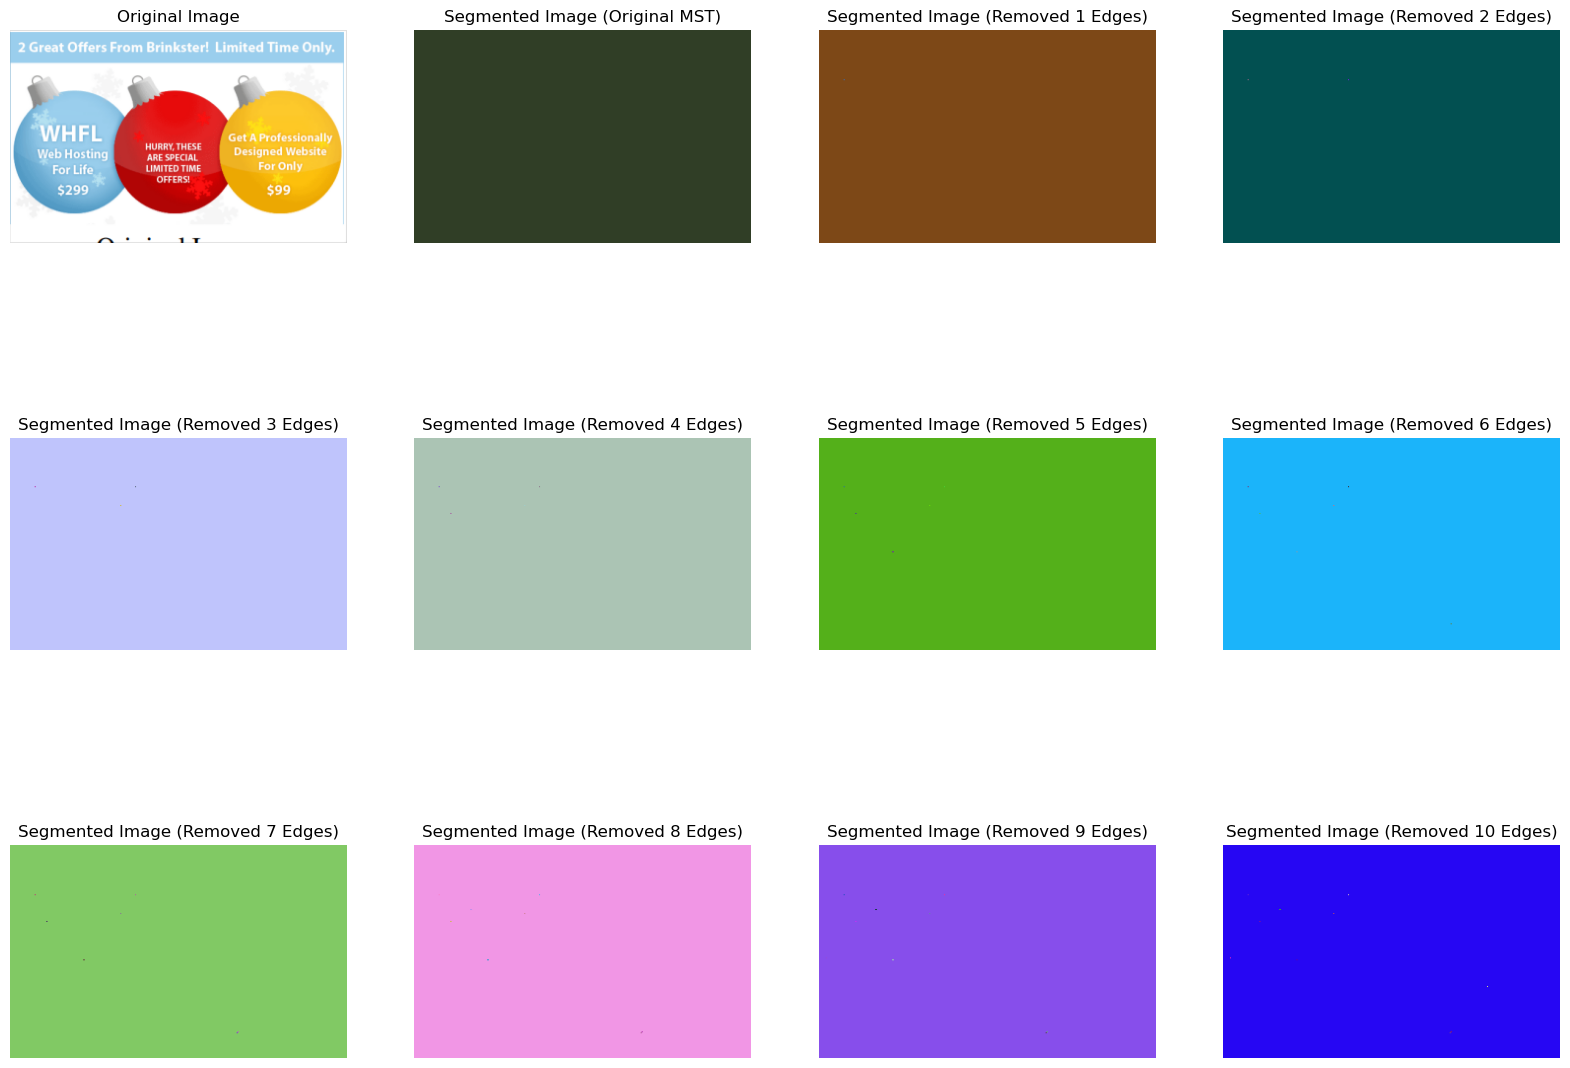

In [5]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("/home/voy/space/cud/dcrun/images/xmas.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get image dimensions
height, width, _ = image.shape

# Convert image to a graph
G = nx.Graph()

# Add nodes for each pixel
for y in range(height):
    for x in range(width):
        G.add_node((x, y), color=tuple(image[y, x]))

# Add edges between neighboring pixels
for y in range(height):
    for x in range(width):
        if x < width - 1:
            color_diff = np.linalg.norm(image[y, x] - image[y, x + 1])
            G.add_edge((x, y), (x + 1, y), weight=color_diff)
        if y < height - 1:
            color_diff = np.linalg.norm(image[y, x] - image[y + 1, x])
            G.add_edge((x, y), (x, y + 1), weight=color_diff)

# Compute the Minimum Spanning Tree (MST)
mst = nx.minimum_spanning_tree(G)


# Function to segment image using MST
def segment_image(mst):
    segments = np.zeros((height, width, 3), dtype=np.uint8)
    for component in nx.connected_components(mst):
        color = np.random.randint(0, 255, 3)
        for node in component:
            segments[node[1], node[0]] = color
    return segments


# Plot original segmentation
segments_original = segment_image(mst)

# Find the longest edges and remove them one by one
edges_to_remove = sorted(
    mst.edges(data=True), key=lambda t: t[2]["weight"], reverse=True
)[:10]

# Plot the segmentations after each edge removal
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# Original image
axes[0].imshow(image)
axes[0].axis("off")
axes[0].set_title("Original Image")

# Original segmentation
axes[1].imshow(segments_original)
axes[1].axis("off")
axes[1].set_title("Segmented Image (Original MST)")

current_mst = mst.copy()

for i, edge in enumerate(edges_to_remove, start=2):
    current_mst.remove_edge(edge[0], edge[1])
    segments_removed_edge = segment_image(current_mst)
    axes[i].imshow(segments_removed_edge)
    axes[i].axis("off")
    axes[i].set_title(f"Segmented Image (Removed {i-1} Edges)")

# Hide any remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.show()

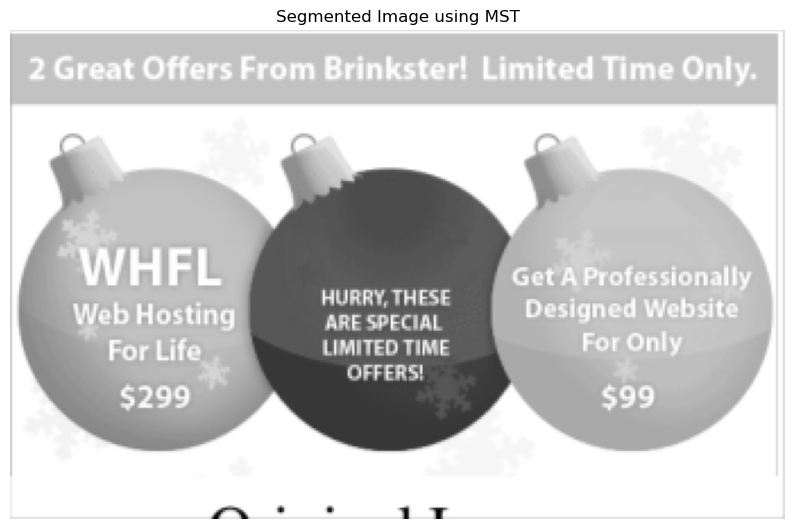

In [7]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load the image
image_path = "/home/voy/space/cud/dcrun/images/xmas.png"
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get image dimensions
rows, cols = gray_image.shape

# Create a graph
G = nx.Graph()

# Add nodes and edges to the graph
for i in range(rows):
    for j in range(cols):
        G.add_node((i, j), intensity=gray_image[i, j])
        if i > 0:
            G.add_edge(
                (i, j),
                (i - 1, j),
                weight=abs(int(gray_image[i, j]) - int(gray_image[i - 1, j])),
            )
        if j > 0:
            G.add_edge(
                (i, j),
                (i, j - 1),
                weight=abs(int(gray_image[i, j]) - int(gray_image[i, j - 1])),
            )

# Compute the Minimum Spanning Tree (MST)
mst = nx.minimum_spanning_tree(G)

# Segment the image based on the MST
segmented_image = np.zeros_like(gray_image)
for u, v, d in mst.edges(data=True):
    segmented_image[u] = gray_image[u]
    segmented_image[v] = gray_image[v]

# Plot the segmented image
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image, cmap="gray")
plt.title("Segmented Image using MST")
plt.axis("off")
plt.show()

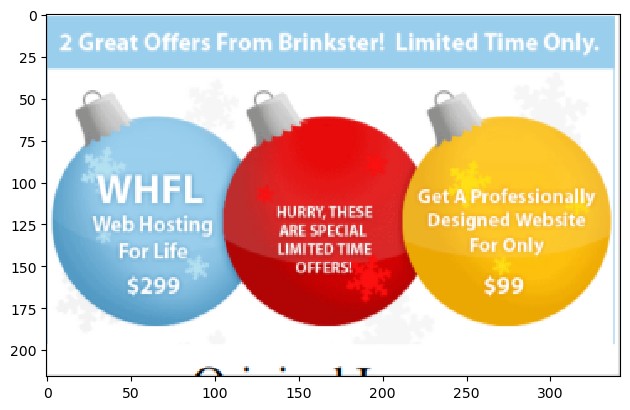

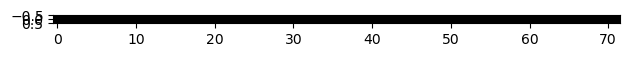

In [14]:
import numpy as np
from skimage import io, color, filters, segmentation
from skimage.graph import rag_mean_color

# Load the image
image = io.imread("/home/voy/space/cud/dcrun/images/xmas.png")

grayscale = color.rgb2gray(image)

# Perform superpixel segmentation using SLIC
segments = segmentation.slic(image, n_segments=100, compactness=10, sigma=1)

# Build the region adjacency graph (RAG)
rag = rag_mean_color(image, labels=segments)

# Perform graph-based segmentation using MST
labels = segmentation.felzenszwalb(rag, scale=100, sigma=0.5, min_size=50)

# Convert the labels to RGB color space for visualization
segmented_image = color.label2rgb(labels, image, kind="avg")

# Display the original and segmented images
io.imshow(image)
io.show()
io.imshow(segmented_image)
io.show()